In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

print(f"Torch version: {torch.__version__}")

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Torch version: 2.9.1+cu128
Device: cpu


In [3]:
class Expert(nn.Module):
    """
    A single expert - Feed-Forward Network (FFN)
    Same as Switch Transformer
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff)
        self.w2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Args:
            x: [num_tokens, d_model]
        Returns:
            output: [num_tokens, d_model]
        """
        hidden = F.gelu(self.w1(x))
        hidden = self.dropout(hidden)
        output = self.w2(hidden)
        output = self.dropout(output)
        return output

# Test Expert
d_model = 512
d_ff = 2048
expert = Expert(d_model, d_ff)
x = torch.randn(10, d_model)
output = expert(x)
print(f"✓ Expert: {x.shape} → {output.shape}")

✓ Expert: torch.Size([10, 512]) → torch.Size([10, 512])


In [4]:
class ExpertChoiceRouter(nn.Module):
    """
    Expert Choice Routing (EC-MoE)
    
    KEY DIFFERENCE from Switch:
    - Switch: Each TOKEN picks an expert
    - Expert Choice: Each EXPERT picks top-k tokens
    
    Advantages:
    ✓ Perfect load balancing (each expert gets exactly k tokens)
    ✓ No auxiliary loss needed
    ✓ Better utilization of all experts
    
    How it works:
    1. Compute affinity scores: [tokens × experts]
    2. Each expert picks top-k tokens with highest affinity
    3. If token chosen by multiple experts → weighted combination
    """
    def __init__(self, d_model, num_experts, expert_capacity):
        super().__init__()
        self.gate = nn.Linear(d_model, num_experts, bias=False)
        self.num_experts = num_experts
        self.expert_capacity = expert_capacity  # k tokens per expert
        
    def forward(self, x):
        """
        Args:
            x: [batch, seq_len, d_model]
            
        Returns:
            dispatch_mask: [num_experts, batch*seq_len] - which tokens each expert processes
            combine_weights: [batch*seq_len, num_experts] - how to combine expert outputs
            router_probs: [batch*seq_len, num_experts] - affinity scores
        """
        batch_size, seq_len, d_model = x.shape
        num_tokens = batch_size * seq_len
        
        # Flatten tokens
        x_flat = x.view(num_tokens, d_model)
        
        # Compute affinity scores: how much each expert wants each token
        router_logits = self.gate(x_flat)  # [num_tokens, num_experts]
        router_probs = F.softmax(router_logits, dim=0)  # Softmax over TOKENS (not experts!)
        
        # Each expert picks top-k tokens
        dispatch_mask = torch.zeros(
            self.num_experts, num_tokens, 
            dtype=torch.bool, device=x.device
        )
        combine_weights = torch.zeros(
            num_tokens, self.num_experts, 
            device=x.device
        )
        
        for expert_id in range(self.num_experts):
            # Get this expert's affinity for all tokens
            expert_affinities = router_probs[:, expert_id]  # [num_tokens]
            
            # Pick top-k tokens
            topk_values, topk_indices = torch.topk(
                expert_affinities, 
                k=min(self.expert_capacity, num_tokens),
                dim=0
            )
            
            # Mark these tokens for this expert
            dispatch_mask[expert_id, topk_indices] = True
            combine_weights[topk_indices, expert_id] = topk_values
        
        # Normalize weights for tokens chosen by multiple experts
        combine_weights = combine_weights / (combine_weights.sum(dim=-1, keepdim=True) + 1e-9)
        
        return dispatch_mask, combine_weights, router_probs.T

# Test Router
num_experts = 8
expert_capacity = 4  # Each expert handles 4 tokens
router = ExpertChoiceRouter(d_model, num_experts, expert_capacity)

x = torch.randn(2, 10, d_model)  # 20 tokens total
dispatch_mask, combine_weights, router_probs = router(x)

print(f"Input: {x.shape}")
print(f"Dispatch mask: {dispatch_mask.shape} (experts × tokens)")
print(f"Combine weights: {combine_weights.shape} (tokens × experts)")
print(f"\nTokens per expert: {dispatch_mask.sum(dim=1)}")
print(f"✓ Perfect load balancing!")

Input: torch.Size([2, 10, 512])
Dispatch mask: torch.Size([8, 20]) (experts × tokens)
Combine weights: torch.Size([20, 8]) (tokens × experts)

Tokens per expert: tensor([4, 4, 4, 4, 4, 4, 4, 4])
✓ Perfect load balancing!


In [5]:
class ExpertChoiceMoELayer(nn.Module):
    """
    Complete Expert Choice MoE Layer
    
    Key advantage: NO auxiliary loss needed!
    Load balancing is guaranteed by design.
    """
    def __init__(
        self,
        d_model=512,
        d_ff=2048,
        num_experts=8,
        expert_capacity=None,  # If None, auto-compute
        dropout=0.1
    ):
        super().__init__()
        self.num_experts = num_experts
        self.d_model = d_model
        
        # Auto-compute capacity if not provided
        # Rule of thumb: capacity = (total_tokens / num_experts) * capacity_factor
        self.expert_capacity = expert_capacity
        
        # Router
        self.router = ExpertChoiceRouter(d_model, num_experts, expert_capacity or 1)
        
        # Experts
        self.experts = nn.ModuleList([
            Expert(d_model, d_ff, dropout) for _ in range(num_experts)
        ])
        
    def forward(self, x):
        """
        Args:
            x: [batch, seq_len, d_model]
            
        Returns:
            output: [batch, seq_len, d_model]
        """
        batch_size, seq_len, d_model = x.shape
        num_tokens = batch_size * seq_len
        
        # Auto-compute capacity if needed
        if self.expert_capacity is None:
            self.router.expert_capacity = (num_tokens + self.num_experts - 1) // self.num_experts
        
        # Route tokens
        dispatch_mask, combine_weights, router_probs = self.router(x)
        
        # Flatten input
        x_flat = x.view(num_tokens, d_model)
        
        # Process tokens through experts
        expert_outputs = torch.zeros(num_tokens, self.num_experts, d_model, device=x.device)
        
        for expert_id in range(self.num_experts):
            # Get tokens for this expert
            token_indices = dispatch_mask[expert_id]
            
            if token_indices.any():
                expert_input = x_flat[token_indices]
                expert_output = self.experts[expert_id](expert_input)
                expert_outputs[token_indices, expert_id] = expert_output
        
        # Combine expert outputs using weights
        output_flat = torch.einsum('te,ted->td', combine_weights, expert_outputs)
        
        # Reshape back
        output = output_flat.view(batch_size, seq_len, d_model)
        
        return output

# Test Expert Choice MoE
ec_moe = ExpertChoiceMoELayer(
    d_model=512,
    d_ff=2048,
    num_experts=8,
    expert_capacity=4,
    dropout=0.1
)

x = torch.randn(2, 10, 512)
output = ec_moe(x)

print(f"Input:  {x.shape}")
print(f"Output: {output.shape}")
print(f"✓ Expert Choice MoE working!")
print(f"✓ No auxiliary loss needed!")

Input:  torch.Size([2, 10, 512])
Output: torch.Size([2, 10, 512])
✓ Expert Choice MoE working!
✓ No auxiliary loss needed!


In [6]:
class MultiHeadAttention(nn.Module):
    """Standard multi-head attention"""
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.shape
        
        Q = self.w_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.w_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.w_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        
        out = torch.matmul(attn, V)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        out = self.w_o(out)
        
        return out


class ExpertChoiceTransformerLayer(nn.Module):
    """
    Complete Expert Choice Transformer Layer
    Attention + Expert Choice MoE
    """
    def __init__(
        self,
        d_model=512,
        num_heads=8,
        d_ff=2048,
        num_experts=8,
        expert_capacity=None,
        dropout=0.1
    ):
        super().__init__()
        
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.moe = ExpertChoiceMoELayer(d_model, d_ff, num_experts, expert_capacity, dropout)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Self-attention
        residual = x
        x = self.norm1(x)
        attn_out = self.self_attn(x, mask)
        x = residual + self.dropout(attn_out)
        
        # Expert Choice MoE
        residual = x
        x = self.norm2(x)
        moe_out = self.moe(x)
        x = residual + self.dropout(moe_out)
        
        return x

# Test complete layer
ec_transformer = ExpertChoiceTransformerLayer(
    d_model=512,
    num_heads=8,
    d_ff=2048,
    num_experts=8,
    expert_capacity=4,
    dropout=0.1
)

x = torch.randn(2, 10, 512)
output = ec_transformer(x)

print(f"Input:  {x.shape}")
print(f"Output: {output.shape}")
print(f"✓ Expert Choice Transformer working!")

Input:  torch.Size([2, 10, 512])
Output: torch.Size([2, 10, 512])
✓ Expert Choice Transformer working!


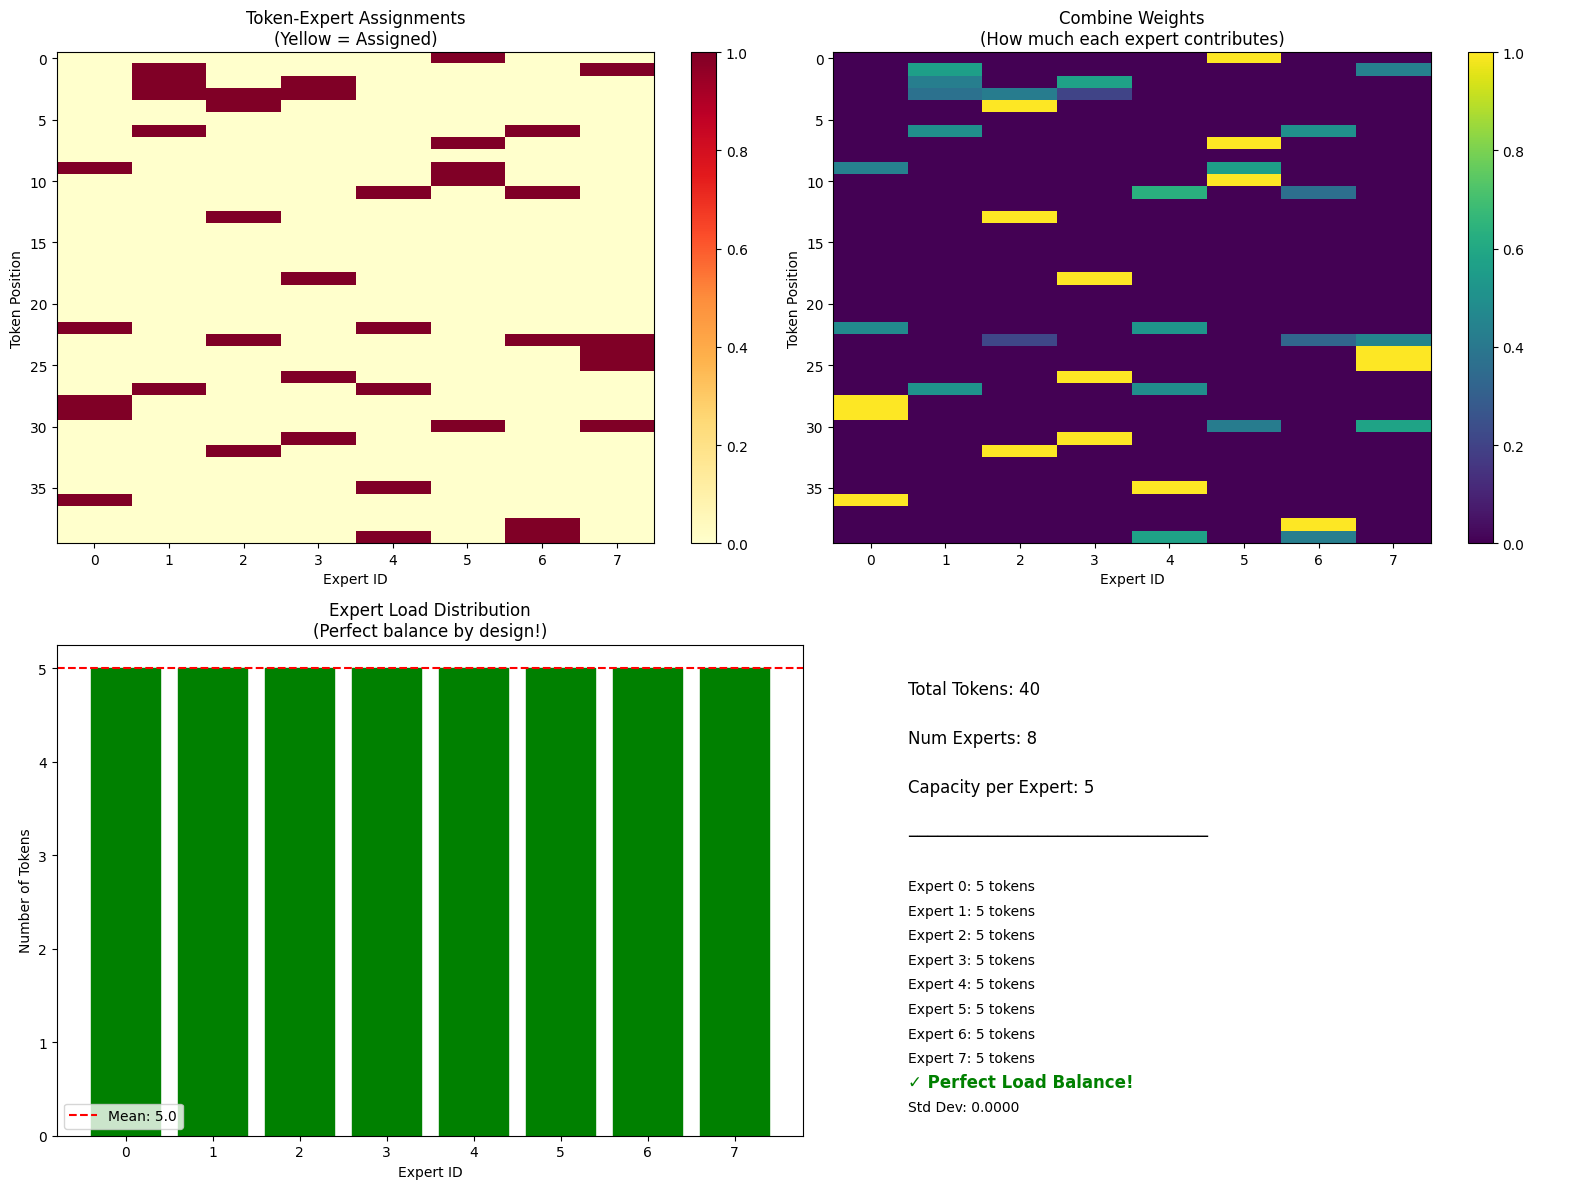


📊 Expert Choice Routing Statistics:
Total tokens: 40
Number of experts: 8
Capacity per expert: 5

Expert Utilization:
  Expert 0:   5 tokens
  Expert 1:   5 tokens
  Expert 2:   5 tokens
  Expert 3:   5 tokens
  Expert 4:   5 tokens
  Expert 5:   5 tokens
  Expert 6:   5 tokens
  Expert 7:   5 tokens

Load Balance Metrics:
  Mean: 5.00
  Std:  0.0000
  Min:  5
  Max:  5

✓ Expert Choice guarantees perfect balance!


In [7]:
def visualize_expert_choice(model, x, token_labels=None):
    """
    Visualize Expert Choice routing pattern
    Shows which tokens each expert selected
    """
    moe_layer = model.moe if hasattr(model, 'moe') else model
    
    with torch.no_grad():
        dispatch_mask, combine_weights, router_probs = moe_layer.router(x)
    
    batch_size, seq_len, _ = x.shape
    num_tokens = batch_size * seq_len
    num_experts = moe_layer.num_experts
    
    # Convert to numpy
    dispatch_mask_np = dispatch_mask.cpu().numpy()
    combine_weights_np = combine_weights.cpu().numpy()
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Token-Expert Assignment Matrix
    ax = axes[0, 0]
    # Transpose to show: rows=tokens, cols=experts
    assignment_matrix = dispatch_mask_np.T.astype(float)
    im = ax.imshow(assignment_matrix, cmap='YlOrRd', aspect='auto')
    ax.set_xlabel('Expert ID')
    ax.set_ylabel('Token Position')
    ax.set_title('Token-Expert Assignments\n(Yellow = Assigned)')
    plt.colorbar(im, ax=ax)
    
    # Plot 2: Combine Weights Heatmap
    ax = axes[0, 1]
    im = ax.imshow(combine_weights_np, cmap='viridis', aspect='auto')
    ax.set_xlabel('Expert ID')
    ax.set_ylabel('Token Position')
    ax.set_title('Combine Weights\n(How much each expert contributes)')
    plt.colorbar(im, ax=ax)
    
    # Plot 3: Expert Load Distribution
    ax = axes[1, 0]
    expert_loads = dispatch_mask_np.sum(axis=1)
    bars = ax.bar(range(num_experts), expert_loads)
    ax.axhline(y=expert_loads.mean(), color='r', linestyle='--', 
               label=f'Mean: {expert_loads.mean():.1f}')
    ax.set_xlabel('Expert ID')
    ax.set_ylabel('Number of Tokens')
    ax.set_title('Expert Load Distribution\n(Perfect balance by design!)')
    ax.legend()
    
    # Color bars
    for i, (bar, load) in enumerate(zip(bars, expert_loads)):
        bar.set_color('green')  # All green - perfect balance!
    
    # Plot 4: Tokens per Expert (detailed)
    ax = axes[1, 1]
    expert_counts = dispatch_mask_np.sum(axis=1)
    token_counts = dispatch_mask_np.sum(axis=0)
    
    ax.text(0.1, 0.9, f"Total Tokens: {num_tokens}", transform=ax.transAxes, fontsize=12)
    ax.text(0.1, 0.8, f"Num Experts: {num_experts}", transform=ax.transAxes, fontsize=12)
    ax.text(0.1, 0.7, f"Capacity per Expert: {moe_layer.router.expert_capacity}", 
            transform=ax.transAxes, fontsize=12)
    ax.text(0.1, 0.6, "─" * 30, transform=ax.transAxes, fontsize=12)
    
    for i in range(num_experts):
        ax.text(0.1, 0.5 - i*0.05, f"Expert {i}: {expert_counts[i]} tokens", 
                transform=ax.transAxes, fontsize=10)
    
    ax.text(0.1, 0.1, f"✓ Perfect Load Balance!", 
            transform=ax.transAxes, fontsize=12, color='green', weight='bold')
    ax.text(0.1, 0.05, f"Std Dev: {expert_counts.std():.4f}", 
            transform=ax.transAxes, fontsize=10)
    
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n📊 Expert Choice Routing Statistics:")
    print(f"{'='*50}")
    print(f"Total tokens: {num_tokens}")
    print(f"Number of experts: {num_experts}")
    print(f"Capacity per expert: {moe_layer.router.expert_capacity}")
    print(f"\nExpert Utilization:")
    for i in range(num_experts):
        print(f"  Expert {i}: {expert_counts[i]:3d} tokens")
    
    print(f"\nLoad Balance Metrics:")
    print(f"  Mean: {expert_counts.mean():.2f}")
    print(f"  Std:  {expert_counts.std():.4f}")
    print(f"  Min:  {expert_counts.min()}")
    print(f"  Max:  {expert_counts.max()}")
    print(f"\n✓ Expert Choice guarantees perfect balance!")

# Test visualization
ec_moe = ExpertChoiceMoELayer(
    d_model=512, 
    num_experts=8, 
    expert_capacity=5
)
x = torch.randn(2, 20, 512)
visualize_expert_choice(ec_moe, x)